<a href="https://colab.research.google.com/github/MarwanAhmed20/Neural-Style-Transfer-with-TensorFlow-and-PyTorch/blob/main/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensor

In [ ]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Download images and choose a style image and a content image:

In [ ]:
content_path = '/content/YellowLabradorLooking_new.jpg'

style_path = '/content/neural_style_transfer_5_1.jpg'


## Visualize the input

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Create a simple function to display an image:

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

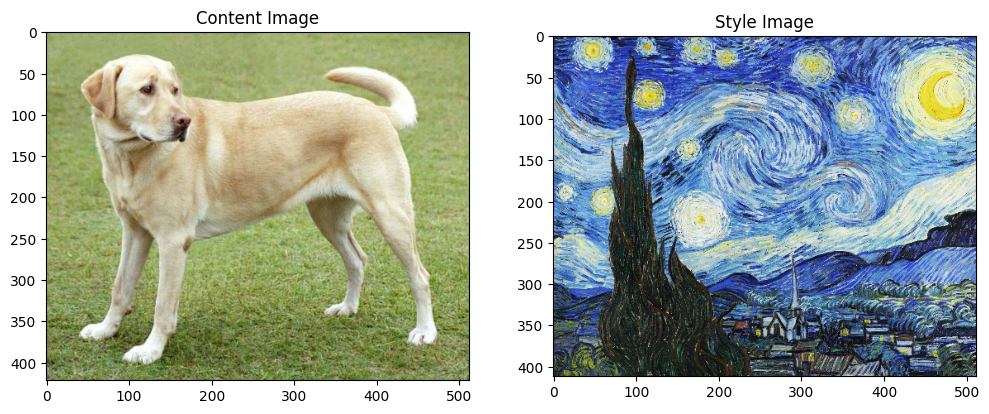

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Fast Style Transfer using TF-Hub

This tutorial demonstrates the original style-transfer algorithm, which optimizes the image content to a particular style. Before getting into the details, let's see how the [TensorFlow Hub model](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) does this:

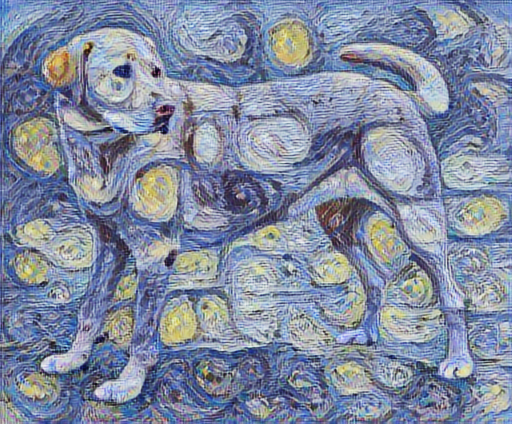

In [ ]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

## Define content and style representations

Use the intermediate layers of the model to get the *content* and *style* representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like *wheels* or *eyes*. In this case, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.


Load a [VGG19](https://keras.io/api/applications/vgg/#vgg19-function) and test run it on our image to ensure it's used correctly:

In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574710816/574710816 [==============================] - 7s 0us/step


TensorShape([1, 1000])

In [ ]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

35363/35363 [==============================] - 0s 0us/step


[('Labrador_retriever', 0.49317107),
 ('golden_retriever', 0.23665293),
 ('kuvasz', 0.03635751),
 ('Chesapeake_Bay_retriever', 0.024182767),
 ('Greater_Swiss_Mountain_dog', 0.018646102)]

Now load a `VGG19` without the classification head, and list the layer names

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80134624/80134624 [==============================] - 0s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Choose intermediate layers from the network to represent the style and content of the image:


In [ ]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### Intermediate layers for style and content

So why do these intermediate outputs within our pretrained image classification network allow us to define style and content representations?

At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image. This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

This is also a reason why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor. By accessing intermediate layers of the model, you're able to describe the content and style of input images.

## Build the model

The networks in `tf.keras.applications` are designed so you can easily extract the intermediate layer values using the Keras functional API.

To define a model using the functional API, specify the inputs and outputs:

`model = Model(inputs, outputs)`

This following function builds a VGG19 model that returns a list of intermediate layer outputs:

In [ ]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

And to create the model:

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 412, 512, 64)
  min:  0.0
  max:  796.0274
  mean:  32.39361

block2_conv1
  shape:  (1, 206, 256, 128)
  min:  0.0
  max:  3807.6765
  mean:  200.55374

block3_conv1
  shape:  (1, 103, 128, 256)
  min:  0.0
  max:  8727.893
  mean:  193.6475

block4_conv1
  shape:  (1, 51, 64, 512)
  min:  0.0
  max:  17986.469
  mean:  745.58185

block5_conv1
  shape:  (1, 25, 32, 512)
  min:  0.0
  max:  4104.9336
  mean:  60.980324



## Calculate style

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

This can be implemented concisely using the `tf.linalg.einsum` function:

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extract style and content


Build a model that returns the style and content tensors.

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

When called on an image, this model returns the gram matrix (style) of the `style_layers` and content of the `content_layers`:

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.005522845
    max:  28014.555
    mean:  263.79022

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.484
    mean:  9100.949

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.44
    mean:  7660.976

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320502.0
    mean:  134288.84

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.37
    mean:  1487.0378

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8796
    mean:  13.764149


## Run gradient descent

With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Set your style and content target values:

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Define a `tf.Variable` to contain the image to optimize. To make this quick, initialize it with the content image (the `tf.Variable` must be the same shape as the content image):

In [ ]:
image = tf.Variable(content_image)

Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Create an optimizer. The paper recommends LBFGS, but Adam works okay, too:

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [ ]:
style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Use `tf.GradientTape` to update the image.

In [ ]:
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Now run a few steps to test:

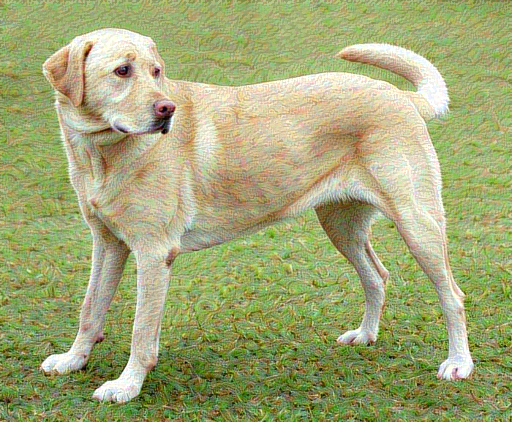

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

In [ ]:
def save(target, i):
  #the image needs to be denormalized first
  denormalization = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
  #remove the additional dimension
  img = target.clone().squeeze()
  img = denormalization(img).clamp(0, 1)
  save_image(img, f'result_tf_{i}.png')

Since it's working, perform a longer optimization:

In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
  if step%50 == 0:
    print(f'step: {step}, content loss: {content_loss.item()}, style loss: {style_loss.item()}')
  if step%100 == 0:
    save(target_img, step)

end = time.time()
print("Total time: {:.1f}".format(end-start))

step: 100, content loss: 26.359676361083984, style loss: 397.5235900878906
step: 200, content loss: 26.359676361083984, style loss: 397.5235900878906
step: 300, content loss: 26.359676361083984, style loss: 397.5235900878906
step: 400, content loss: 26.359676361083984, style loss: 397.5235900878906
step: 500, content loss: 26.359676361083984, style loss: 397.5235900878906
step: 600, content loss: 26.359676361083984, style loss: 397.5235900878906
step: 700, content loss: 26.359676361083984, style loss: 397.5235900878906
step: 800, content loss: 26.359676361083984, style loss: 397.5235900878906
step: 900, content loss: 26.359676361083984, style loss: 397.5235900878906
step: 1000, content loss: 26.359676361083984, style loss: 397.5235900878906
Total time: 76.7


## Total variation loss

One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the *total variation loss*:

In [ ]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

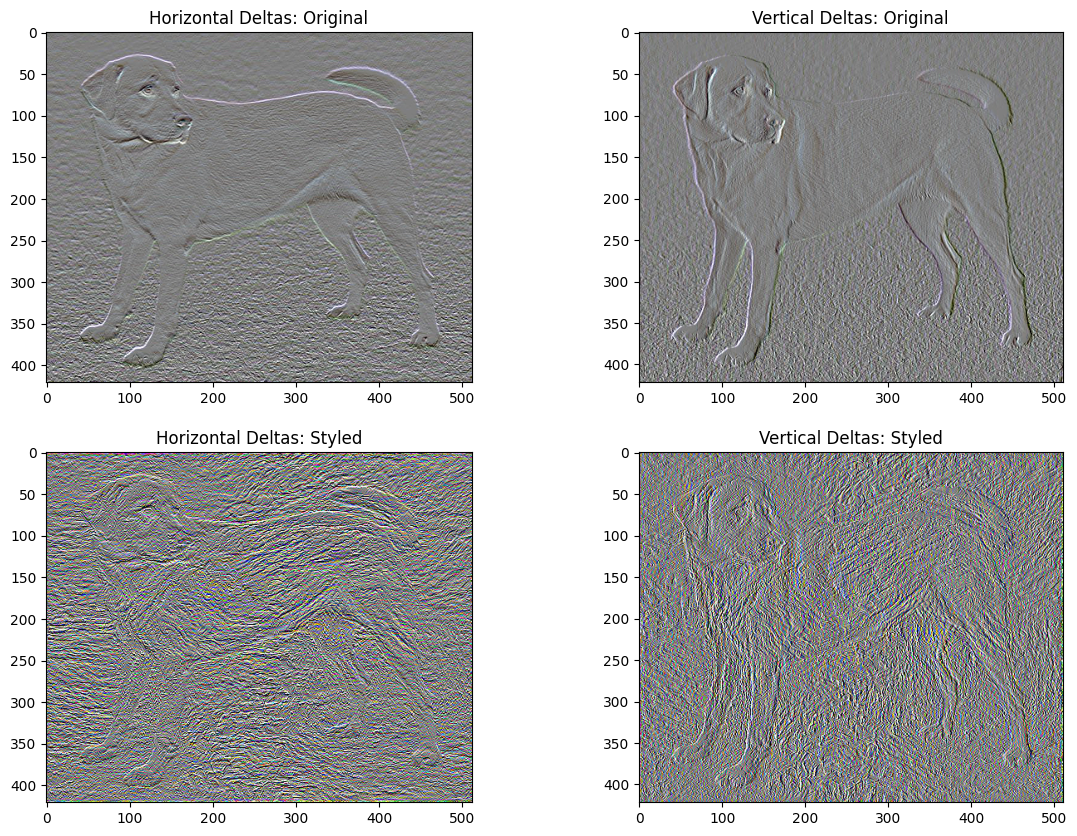

In [ ]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

This shows how the high frequency components have increased.

Also, this high frequency component is basically an edge-detector. You can get similar output from the Sobel edge detector, for example:

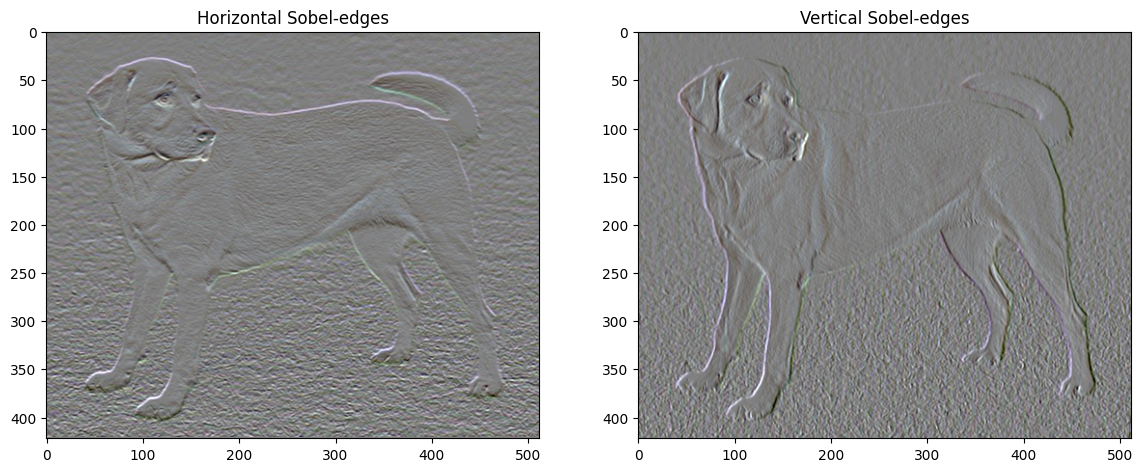

In [ ]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

The regularization loss associated with this is the sum of the squares of the values:

In [ ]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [ ]:
total_variation_loss(image).numpy()

170432.34

That demonstrated what it does. But there's no need to implement it yourself, TensorFlow includes a standard implementation:

In [ ]:
tf.image.total_variation(image).numpy()

array([170432.34], dtype=float32)

## Re-run the optimization

Choose a weight for the `total_variation_loss`:

In [ ]:
total_variation_weight=30

Now include it in the `train_step` function:

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Reinitialize the image-variable and the optimizer:

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

And run the optimization:

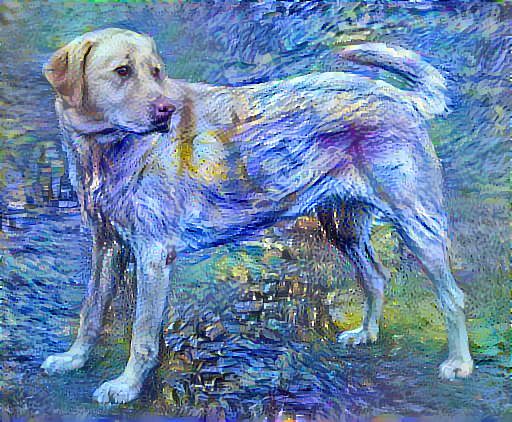

Train step: 1000
Total time: 79.2


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

Finally, save the result:

In [ ]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Torch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optimization

import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.utils import save_image

from tqdm.notebook import tqdm
from PIL import Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
vgg19 = models.vgg19(pretrained=True).to(device).eval()


In [ ]:
from torchsummary import summary

# Assuming your VGG model is named 'vgg'
summary(vgg19, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:

class VGG(nn.Module):
  def __init__(self):
    super(VGG, self).__init__()
    self.select_features = ['0', '5', '10', '19', '28'] #conv layers 5 for content and style
    self.vgg = models.vgg19(pretrained=True).features

  def forward(self, output):
    features = []
    for name, layer in self.vgg._modules.items():
      output = layer(output)
      if name in self.select_features:
        features.append(output)
    return features

#load the model
vgg_fet = VGG().to(device).eval()

In [ ]:
def load_img(path):
  img = Image.open(path)
  img = loader(img).unsqueeze(0)
  return img.to(device)

In [ ]:

#the 3 needed images
content_img = load_img('/content/YellowLabradorLooking_new.jpg')
style_img = load_img('/content/neural_style_transfer_5_1.jpg')
#we can start from a random noise generated image or
#just copy the content image as a starting point
target_img = content_img.clone().requires_grad_(True)

In [ ]:
img_size = (512,512)
#preprocessing of the images
loader = transforms.Compose([
                             transforms.Resize(img_size),
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

#the optimizer; in the paper they are using LBFGS, but we can go ahead and use Adam since it's generally more adequate
optimizer = optimization.Adam([target_img], lr=0.001)

steps = 1000
alpha = 1 #content wight
beta = 10000 #style weight



In [ ]:
style_img.shape

torch.Size([1, 3, 512, 512])

In [ ]:
def get_content_loss(target, content):
  return torch.mean((target-content)**2)

In [ ]:

def gram_matrix(input, c, h, w):
  #c-channels; h-height; w-width
  input = input.view(c, h*w)
  #matrix multiplication on its own transposed form
  G = torch.mm(input, input.t())
  return G

def get_style_loss(target, style):
  _, c, h, w = target.size()
  G = gram_matrix(target, c, h, w) #gram matrix for the target image
  S = gram_matrix(style, c, h, w) #gram matrix for the style image
  return torch.mean((G-S)**2)/(c*h*w)

In [ ]:
def save(target, i):
  #the image needs to be denormalized first
  denormalization = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
  #remove the additional dimension
  img = target.clone().squeeze()
  img = denormalization(img).clamp(0, 1)
  save_image(img, f'result_torch_{i}.png')

In [ ]:
import time
start = time.time()

for step in tqdm(range(steps)):
  #get feature vectors representations for every image
  target_feature = vgg_fet(target_img)
  content_feature = vgg_fet(content_img)
  style_feature = vgg_fet(style_img)

  #initiate the losses
  style_loss = 0
  content_loss = 0

  for target, content, style in zip(target_feature, content_feature, style_feature):
    content_loss += get_content_loss(target, content)
    style_loss += get_style_loss(target, style)

  #calculate the total loss according to the original paper
  total_loss = alpha*content_loss+beta*style_loss

  #set parameters to zero
  optimizer.zero_grad()
  #compute the gradient
  total_loss.backward()
  #update parameters
  optimizer.step()

  #uncomment if you want to follow the progress
  if step%50 == 0:
    print(f'step: {step}, content loss: {content_loss.item()}, style loss: {style_loss.item()}')
  if step%100 == 0:
    save(target_img, step)

end = time.time()
print("Total time: {:.1f}".format(end-start))

  0%|          | 0/1000 [00:00<?, ?it/s]

step: 0, content loss: 0.0, style loss: 2343.5458984375
step: 50, content loss: 7.115474700927734, style loss: 1765.4813232421875
step: 100, content loss: 13.305109024047852, style loss: 1262.5015869140625
step: 150, content loss: 15.7818021774292, style loss: 1051.573974609375
step: 200, content loss: 17.614418029785156, style loss: 922.7086791992188
step: 250, content loss: 19.033527374267578, style loss: 832.502685546875
step: 300, content loss: 20.166810989379883, style loss: 765.3413696289062
step: 350, content loss: 21.079593658447266, style loss: 712.7920532226562
step: 400, content loss: 21.827774047851562, style loss: 669.8829345703125
step: 450, content loss: 22.455835342407227, style loss: 633.5127563476562
step: 500, content loss: 22.9855899810791, style loss: 601.8449096679688
step: 550, content loss: 23.459972381591797, style loss: 573.6622924804688
step: 600, content loss: 23.889244079589844, style loss: 548.2025756835938
step: 650, content loss: 24.281604766845703, styl